# MRI Transfer Learning

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import scipy

## An ImageNet classifier

You'll start by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

### Download the classifier

Use `hub.KerasLayer` to load a [MobileNetV2 model](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) from TensorFlow Hub. Any [compatible image classifier model](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [3]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" #@param {type:"string"}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [5]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [6]:
# plt.imshow(grace_hopper)
# plt.axis('off')
# predicted_class_name = imagenet_labels[predicted_class]
# _ = plt.title("Prediction: " + predicted_class_name.title())

In [7]:
batch_size = 32
img_height = 224
img_width = 224

data_root = 'E:\dev\data\mri\sorted'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3064 files belonging to 3 classes.
Using 2452 files for training.


The selected MRI dataset has three classes.

In [8]:
class_names = np.array(train_ds.class_names)
print(class_names)

['glioma' 'meningioma' 'pituitary']


TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `Rescaling` layer to achieve this.

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [12]:
result_batch = classifier.predict(train_ds)

In [13]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pick', 'spotlight', 'mouse', ..., 'spotlight', 'ski mask',
       'crash helmet'], dtype='<U30')

Now check how these predictions line up with the images:

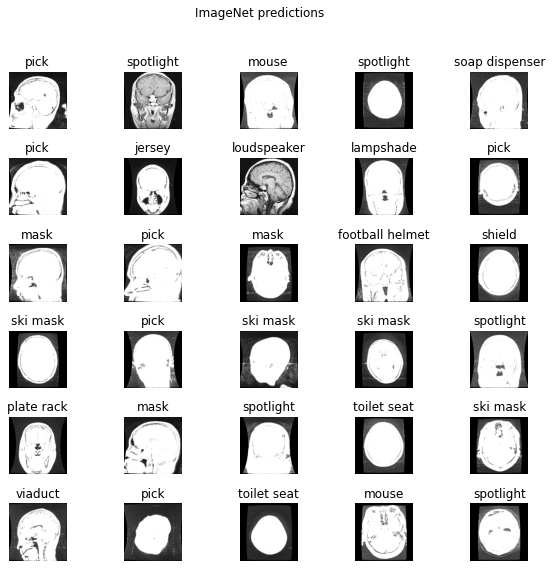

In [14]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [15]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [16]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

It returns a 1280-length vector for each image:

In [17]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [18]:
num_classes = len(class_names)

# model = tf.keras.Sequential([
#   feature_extractor_layer,
#   tf.keras.layers.Dense(num_classes)
# ])

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 2,915,395
Trainable params: 657,411
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
predictions = model(image_batch)

In [20]:
predictions.shape

TensorShape([32, 3])

### Train the model

Use compile to configure the training process:

In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [22]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds,
                    epochs=20,
                    callbacks=[batch_stats_callback])

Epoch 1/20
77/77 [==============================] - 2s 19ms/step - loss: 0.3063 - acc: 0.8500
Epoch 2/20
77/77 [==============================] - 1s 19ms/step - loss: 0.1341 - acc: 1.0000
Epoch 3/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0985 - acc: 1.0000
Epoch 4/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0800 - acc: 1.0000
Epoch 5/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0735 - acc: 1.0000
Epoch 6/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0582 - acc: 1.0000
Epoch 7/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0517 - acc: 1.0000
Epoch 8/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0578 - acc: 1.0000
Epoch 9/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0204 - acc: 1.0000
Epoch 10/20
77/77 [==============================] - 1s 19ms/step - loss: 0.0918 - acc: 0.9500
Epoch 11/20
77/77 [==============================] - 1s 19m

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

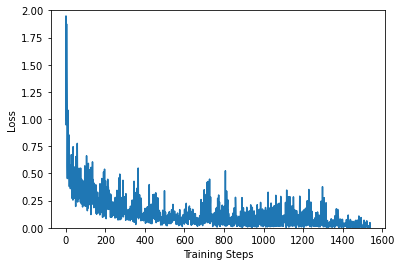

In [23]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

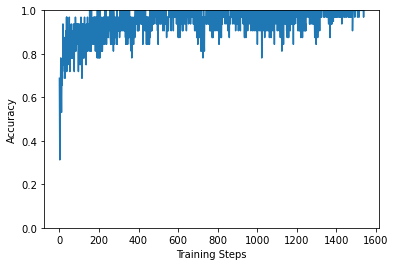

In [24]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [25]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

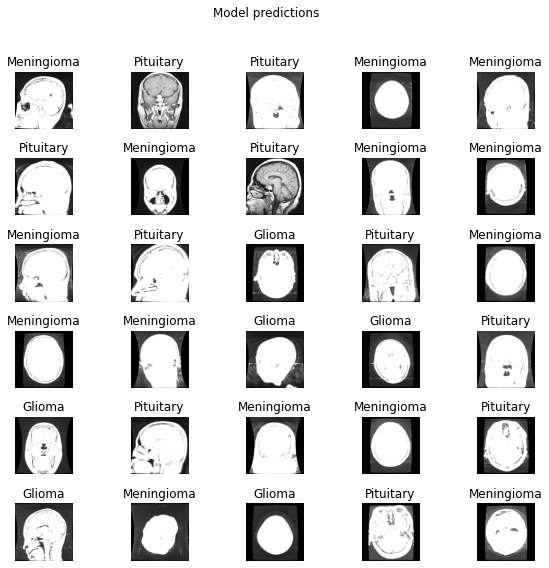

In [26]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a SavedModel for use later on.

In [27]:
t = time.time()

# export_path = "/tmp/saved_models/{}".format(int(t))
export_path = "../models/{}".format(int(t))
model.save(export_path)

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/1607529342\assets
INFO:tensorflow:Assets written to: ../models/1607529342\assets


'../models/1607529342'

In [28]:
reloaded = tf.keras.models.load_model(export_path)

In [29]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [30]:
abs(reloaded_result_batch - result_batch).max()

0.0